In [1]:
import pandas as pd
from util import *
import plotly.graph_objects as go

import datetime
import locale

from IPython.display import display, Markdown

In [37]:
dataset_date = "2024-03-18 13-22"
dataset_date_obj = datetime.datetime.strptime(dataset_date, "%Y-%m-%d %H-%M")
datasets = {
    "Semua TPS": "https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/2024-03-18.13-22.csv",
    "Suara Sesuai": "https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_sesuai.csv",
    "Suara Tidak Sesuai": "https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_tidak_sesuai.csv",
    "Suara Lebih": "https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_lebih.csv",
    "Suara Kurang": "https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_kurang.csv"
}

def dataset_date_str():
    return dataset_date_obj.strftime("%d %b %Y %H:%M")

In [3]:
def render_link_md(name):
    return "[%s](%s)" % (name, datasets[name])

In [4]:
pd.set_option('display.max_colwidth', None)
pd.options.plotting.backend = "plotly"

In [5]:
df = pd.read_csv('dataset/%s.csv' % dataset_date, low_memory=False)

In [6]:
additional_col = ['pengguna_dpt', 'pengguna_dptb', 'pengguna_dpk', 
                  'pemilih_dpt_lk', 'pemilih_dpt_pr', 'jumlah_pemilih_dpt', 'pengguna_dpt_lk', 
                  'pengguna_dpt_pr', 'pengguna_dptb_lk', 'pengguna_dptb_pr', 'pengguna_dpk_lk', 'pengguna_dpk_pr']

In [7]:
df.drop(columns=additional_col, inplace=True)

In [8]:
add_web_page(df)

In [9]:
from map_provinsi import *

In [10]:
kota_tps = map_kota_tps(provinsi)
kab_indonesia = filter_kab_indonesia(kota_tps)

In [11]:
add_kota(df, kota_tps)

In [12]:
add_nama_provinsi(df, kode_to_provinsi)

In [13]:
df.insert(9, 'jumlah_pengguna', df.pop(item='jumlah_pengguna'))
df.insert(10, 'jumlah_pengguna_lk', df.pop(item='jumlah_pengguna_lk'))
df.insert(11, 'jumlah_pengguna_pr', df.pop(item='jumlah_pengguna_pr'))

In [14]:
tps_count = df.tps.count()
suara_masuk = df[df.total_suara_paslon > 0]
suara_belum_masuk = df[df.total_suara_paslon == 0]
data_normal = suara_masuk[(suara_masuk.suara_lebih == 0)
    & ((suara_masuk.suara_sah+suara_masuk.suara_tidak_sah) == suara_masuk.total_suara) 
    & (suara_masuk.total_suara == suara_masuk.jumlah_pengguna)
    & ((suara_masuk.jumlah_pengguna_lk+suara_masuk.jumlah_pengguna_pr) == suara_masuk.jumlah_pengguna)]
data_cluttered = suara_masuk[suara_masuk.tps.isin(data_normal.tps) == False]

In [15]:
unequal_jumlah_pengguna = suara_masuk[suara_masuk.total_suara != suara_masuk.jumlah_pengguna]
unequal_total_suara = suara_masuk[(suara_masuk.total_suara != suara_masuk.suara_sah+suara_masuk.suara_tidak_sah)]

In [16]:
inprogress = data_cluttered[(data_cluttered.suara_sah == 0) & (data_cluttered.suara_tidak_sah == 0) & (data_cluttered.total_suara == 0)]
progressed = data_cluttered[data_cluttered.tps.isin(inprogress.tps) == False]

progressed_anomali = progressed[progressed.suara_lebih > 0]
progressed_suara_lebih = progressed_anomali[progressed_anomali.suara_sah > 0]
anomali_suara_sah_nol = progressed_anomali[progressed_anomali.tps.isin(progressed_anomali.tps) == False]

progressed_suara_kurang = progressed[progressed.suara_lebih < 0]

In [17]:
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [38]:
display(Markdown('### Dataset %s WITA' % dataset_date_str()))
display(Markdown("**Unduh Dataset:** %s" % ', '.join([render_link_md(i) for i in datasets])))

### Dataset 18 Mar 2024 13:22 WITA

**Unduh Dataset:** [Semua TPS](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/2024-03-18.13-22.csv), [Suara Sesuai](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_sesuai.csv), [Suara Tidak Sesuai](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_tidak_sesuai.csv), [Suara Lebih](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_lebih.csv), [Suara Kurang](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_kurang.csv)

**Video Penjelasan bisa dilihat di [link youtube ini](https://youtu.be/jelGPskUlFw?si=iNfLnhnXana9AIpX)**

**Progress Data TPS bisa di track di link berikut: [Progress Data TPS](progress.html)**

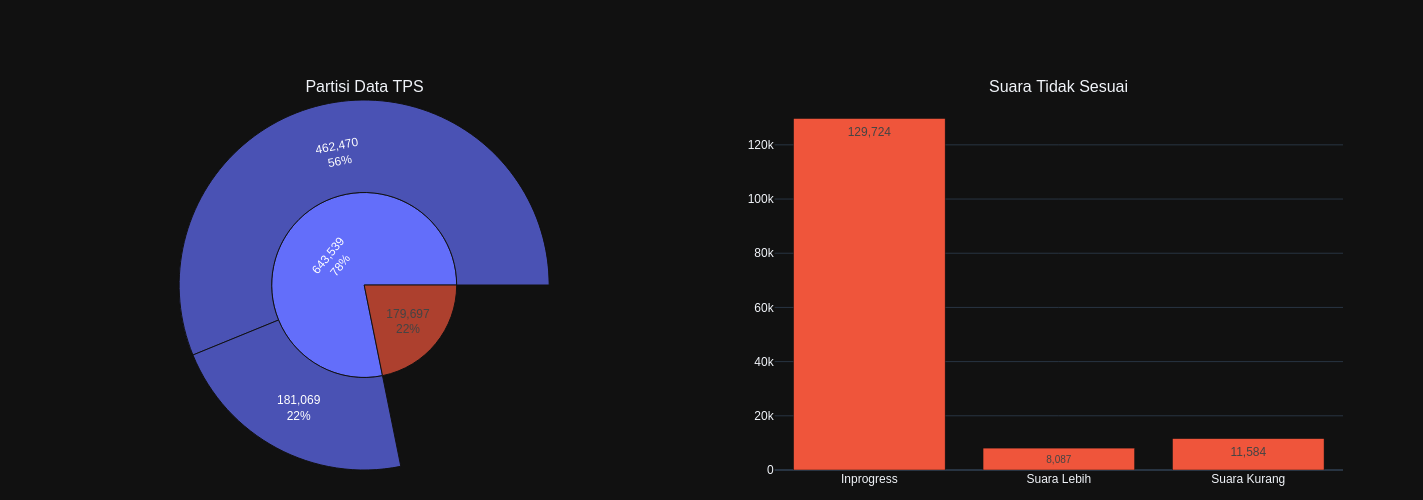

In [19]:
from plotly.subplots import make_subplots

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'bar'}]],
                    subplot_titles=['Partisi Data TPS', "Suara Tidak Sesuai"])

fig.add_trace(go.Sunburst(
    labels=["Masuk", "Belum Masuk", "Suara Sesuai", "Suara Tidak Sesuai"],
    parents=["", "", "Masuk", "Masuk"],
    values=[suara_masuk.tps.count(), suara_belum_masuk.tps.count(), data_normal.tps.count(), data_cluttered.tps.count()],
    branchvalues="total",
    name="Partisi Data"
), 1, 1)

fig.update_traces(textinfo='percent entry+value')

labels=['Total Suara <br>!=<br>Jumlah Pengguna', 'Total Suara<br>!=<br>Suarah Sah+Suara Tidak Sah']
label2 = ["Inprogress", "Suara Lebih", "Suara Kurang"]

cluttered_y = [inprogress.tps.count(), progressed_suara_lebih.tps.count(), progressed_suara_kurang.tps.count()]
incorrect = [unequal_jumlah_pengguna.tps.count(), unequal_total_suara.tps.count()]

fig.add_trace(go.Bar(hoverinfo="x+y", text=[f"{x:,}" for x in cluttered_y], textposition="inside", orientation='v', y=cluttered_y, x=label2, name="Suara Tidak Sesuai"), 1, 2)

fig.update_layout(
    autosize=True,
    height=500,
    margin=dict(b=30)
)
fig.show()

In [20]:
# anomali = df.loc[(df['suara_lebih'] > 0) & (df['suara_sah'] > 0)]

paslon1_unggul_paslon2 = progressed_suara_lebih['paslon01'] > progressed_suara_lebih['paslon02']
paslon1_unggul_paslon3 = progressed_suara_lebih['paslon01'] > progressed_suara_lebih['paslon03']

paslon2_unggul_paslon1 = progressed_suara_lebih['paslon02'] > progressed_suara_lebih['paslon01']
paslon2_unggul_paslon3 = progressed_suara_lebih['paslon02'] > progressed_suara_lebih['paslon03']

paslon3_unggul_paslon1 = progressed_suara_lebih['paslon03'] > progressed_suara_lebih['paslon01']
paslon3_unggul_paslon2 = progressed_suara_lebih['paslon03'] > progressed_suara_lebih['paslon02']

paslon1_eq_paslon2 = progressed_suara_lebih['paslon01'] == progressed_suara_lebih['paslon02']
paslon1_eq_paslon3 = progressed_suara_lebih['paslon01'] == progressed_suara_lebih['paslon03']
paslon2_eq_paslon3 = progressed_suara_lebih['paslon02'] == progressed_suara_lebih['paslon03']

paslon1_lebih = progressed_suara_lebih.loc[paslon1_unggul_paslon2 & paslon1_unggul_paslon3]
paslon2_lebih = progressed_suara_lebih.loc[paslon2_unggul_paslon1 & paslon2_unggul_paslon3]
paslon3_lebih = progressed_suara_lebih.loc[paslon3_unggul_paslon1 & paslon3_unggul_paslon2]

In [21]:
paslon1_kurang = progressed_suara_kurang[(progressed_suara_kurang.paslon01 < progressed_suara_kurang.paslon02) & (progressed_suara_kurang.paslon01 < progressed_suara_kurang.paslon03)]
paslon2_kurang = progressed_suara_kurang[(progressed_suara_kurang.paslon02 < progressed_suara_kurang.paslon01) & (progressed_suara_kurang.paslon02 < progressed_suara_kurang.paslon03)]
paslon3_kurang = progressed_suara_kurang[(progressed_suara_kurang.paslon03 < progressed_suara_kurang.paslon02) & (progressed_suara_kurang.paslon03 < progressed_suara_kurang.paslon01)]

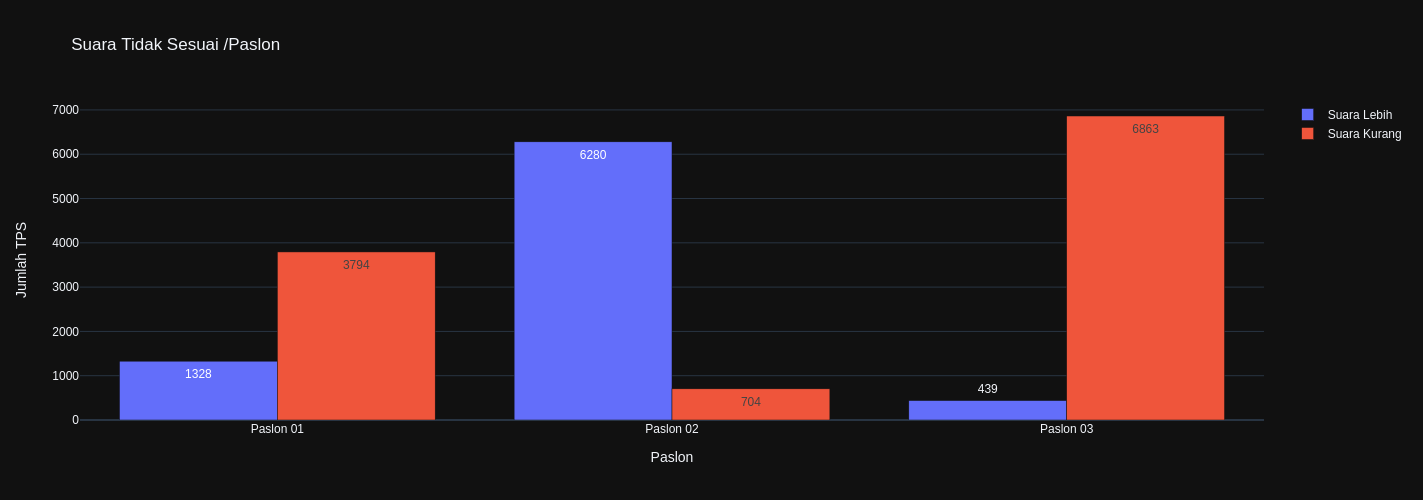

In [22]:
fig = go.Figure()

paslons=['Paslon 01', 'Paslon 02', 'Paslon 03']
data_lebih = [paslon1_lebih.tps.count(), paslon2_lebih.tps.count(), paslon3_lebih.tps.count()]
data_kurang = [paslon1_kurang.tps.count(), paslon2_kurang.tps.count(), paslon3_kurang.tps.count()]

fig.add_trace(go.Bar(name='Suara Lebih', text=data_lebih, x=paslons, y=data_lebih, hoverinfo='name+x+y'))
fig.add_trace(go.Bar(name='Suara Kurang', text=data_kurang, x=paslons, y=data_kurang, hoverinfo='name+x+y'))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="Suara Tidak Sesuai /Paslon",
    xaxis_title="Paslon",
    yaxis_title="Jumlah TPS",
    autosize=True,
    height=500
)
fig.show()


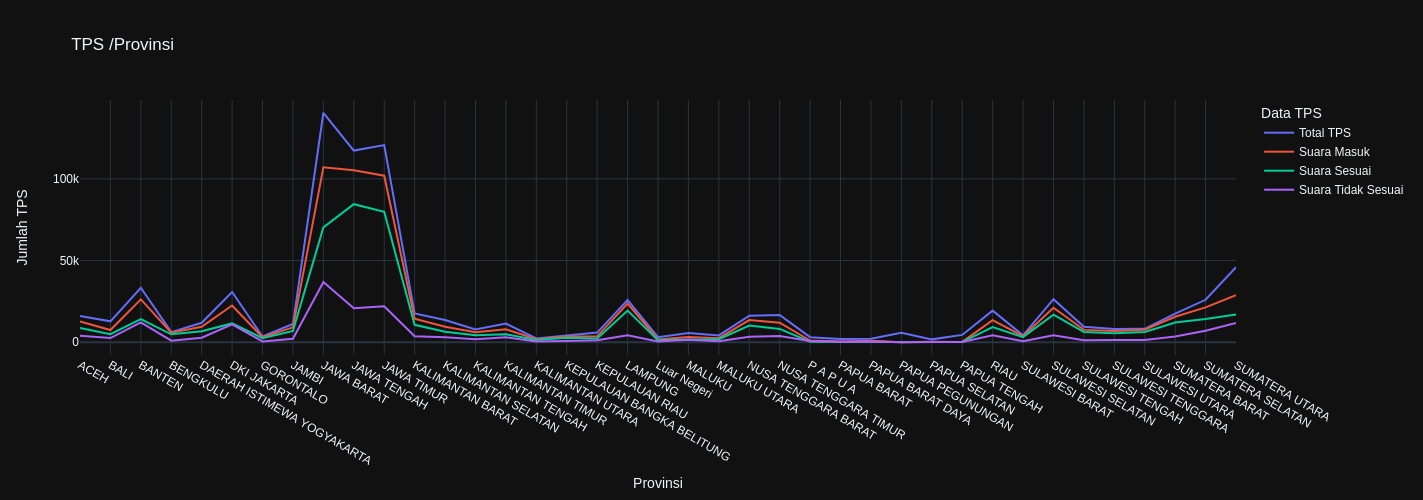

In [23]:
fig = go.Figure()

suara_masuk_group = suara_masuk.groupby('provinsi').tps.count()
df_group = df.groupby('provinsi').tps.count()
data_normal_group = data_normal.groupby('provinsi').tps.count()
data_cluttered_group = data_cluttered.groupby('provinsi').tps.count()

fig.add_trace(go.Scatter(name='Total TPS', y=df_group.values, x=df_group.index))
fig.add_trace(go.Scatter(name='Suara Masuk', y=suara_masuk_group.values, x=suara_masuk_group.index))
fig.add_trace(go.Scatter(name='Suara Sesuai', y=data_normal_group.values, x=data_normal_group.index))
fig.add_trace(go.Scatter(name='Suara Tidak Sesuai', y=data_cluttered_group.values, x=data_cluttered_group.index))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="TPS /Provinsi",
    xaxis_title="Provinsi",
    yaxis_title="Jumlah TPS",
    legend_title="Data TPS",
    autosize=True,
    height=500,)
fig.show()

In [24]:
# fig = go.Figure()

# paslon1_lebih_group = paslon1_lebih.groupby('provinsi').tps.count()
# paslon1_kurang_group = paslon1_kurang.groupby('provinsi').tps.count()

# paslon2_lebih_group = paslon2_lebih.groupby('provinsi').tps.count()
# paslon2_kurang_group = paslon2_kurang.groupby('provinsi').tps.count()

# paslon3_lebih_group = paslon3_lebih.groupby('provinsi').tps.count()
# paslon3_kurang_group = paslon3_kurang.groupby('provinsi').tps.count()

# fig.add_trace(go.Scatter(name='Paslon 01', y=paslon1_lebih_group.values, x=paslon1_lebih_group.index))
# fig.add_trace(go.Scatter(name='Paslon 02', y=paslon2_lebih_group.values, x=paslon2_lebih_group.index))
# fig.add_trace(go.Scatter(name='Paslon 03', y=paslon3_lebih_group.values, x=paslon3_lebih_group.index))

# fig.update_layout(hovermode='x unified')

# fig.update_layout(
#     title="Suara Lebih Paslon /Provinsi",
#     xaxis_title="Provinsi",
#     yaxis_title="Jumlah TPS",
#     legend_title="Suara Lebih",
#     autosize=True,
#     height=500,)
# fig.show()

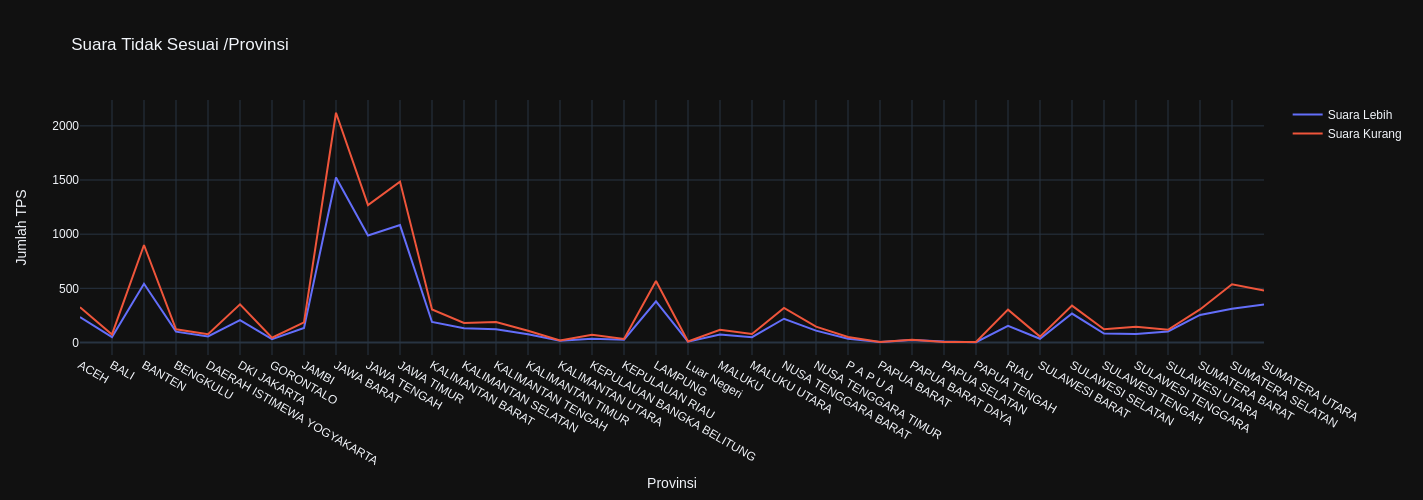

In [25]:
fig = go.Figure()

lebih_group = progressed_suara_lebih.groupby('provinsi').tps.count()
kurang_group = progressed_suara_kurang.groupby('provinsi').tps.count()
fig.add_trace(go.Scatter(name='Suara Lebih', y=lebih_group.values, x=lebih_group.index))
fig.add_trace(go.Scatter(name='Suara Kurang', y=kurang_group.values, x=kurang_group.index))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="Suara Tidak Sesuai /Provinsi",
    xaxis_title="Provinsi",
    yaxis_title="Jumlah TPS",
    autosize=True,
    height=500,)
fig.show()

---

In [39]:
display(Markdown("#### Semua Grafik Di Bawah Menggunakan Data %s" % render_link_md('Suara Sesuai')))

#### Semua Grafik Di Bawah Menggunakan Data [Suara Sesuai](https://github.com/khrlimam/pemilu2024-suara-tps/releases/download/2024-03-18/suara_sesuai.csv)

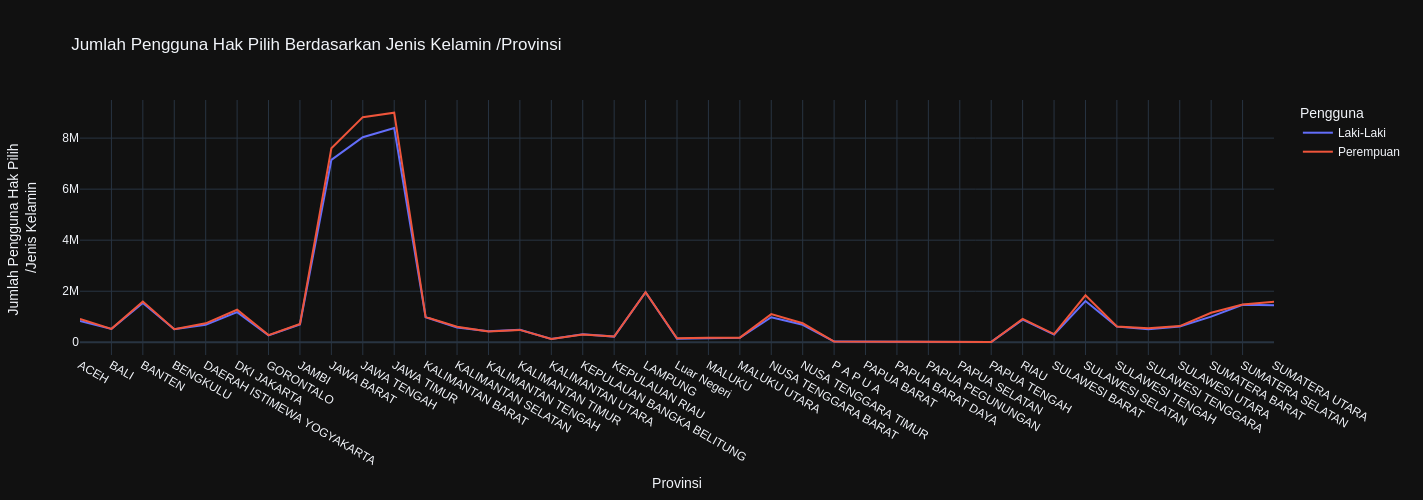

In [27]:
fig = go.Figure()

pengguna_lk_group = data_normal.groupby('provinsi').jumlah_pengguna_lk.sum()
pengguna_pr_group = data_normal.groupby('provinsi').jumlah_pengguna_pr.sum()
pengguna_group = data_normal.groupby('provinsi').jumlah_pengguna.sum()

fig.add_trace(go.Scatter(name='Laki-Laki', hoverinfo="x+name+text", text=[f"{it:,}" for it in pengguna_lk_group.values], y=pengguna_lk_group.values, x=pengguna_lk_group.index))
fig.add_trace(go.Scatter(name='Perempuan', hoverinfo="x+name+text", text=[f"{it:,}" for it in pengguna_pr_group.values], y=pengguna_pr_group.values, x=pengguna_pr_group.index))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="Jumlah Pengguna Hak Pilih Berdasarkan Jenis Kelamin /Provinsi",
    xaxis_title="Provinsi",
    yaxis_title="Jumlah Pengguna Hak Pilih <br>/Jenis Kelamin",
    legend_title="Pengguna",
    autosize=True,
    height=500,)
fig.show()

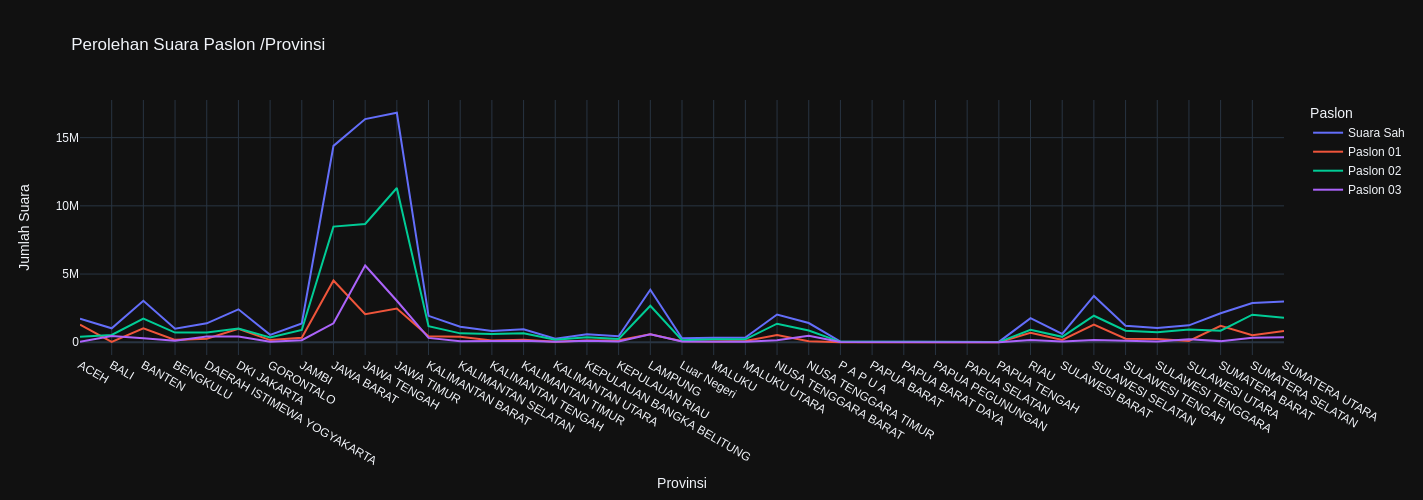

In [28]:
fig = go.Figure()

paslon1_suara_group = data_normal.groupby('provinsi').paslon01.sum()
paslon2_suara_group = data_normal.groupby('provinsi').paslon02.sum()
paslon3_suara_group = data_normal.groupby('provinsi').paslon03.sum()

suara_sah_group = data_normal.groupby('provinsi').suara_sah.sum()
suara_tidak_sah_group = data_normal.groupby('provinsi').suara_tidak_sah.sum()

percentage_suara_paslon1 = (paslon1_suara_group/suara_sah_group*100).round(2)
percentage_suara_paslon2 = (paslon2_suara_group/suara_sah_group*100).round(2)
percentage_suara_paslon3 = (paslon3_suara_group/suara_sah_group*100).round(2)

fig.add_trace(go.Scatter(name='Suara Sah', hoverinfo="x+name+text", text=[f"{it:,}" for it in suara_sah_group.values], y=suara_sah_group.values, x=suara_sah_group.index))
fig.add_trace(go.Scatter(name='Paslon 01', hoverinfo="x+name+text", 
                         text=[f"{suara:,} ({it}%)" for it, suara in zip(percentage_suara_paslon1, paslon1_suara_group)], 
                         y=paslon1_suara_group.values, 
                         x=paslon1_suara_group.index))

fig.add_trace(go.Scatter(name='Paslon 02', hoverinfo="x+name+text", 
                         text=[f"{suara:,} ({it}%)" for it, suara in zip(percentage_suara_paslon2, paslon2_suara_group)], 
                         y=paslon2_suara_group.values, 
                         x=paslon2_suara_group.index))

fig.add_trace(go.Scatter(name='Paslon 03', hoverinfo="x+name+text", 
                         text=[f"{suara:,} ({it}%)" for it, suara in zip(percentage_suara_paslon3, paslon3_suara_group)], 
                         y=paslon3_suara_group.values, 
                         x=paslon3_suara_group.index))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="Perolehan Suara Paslon /Provinsi",
    xaxis_title="Provinsi",
    yaxis_title="Jumlah Suara",
    legend_title="Paslon",
    autosize=True,
    height=500)
fig.show()

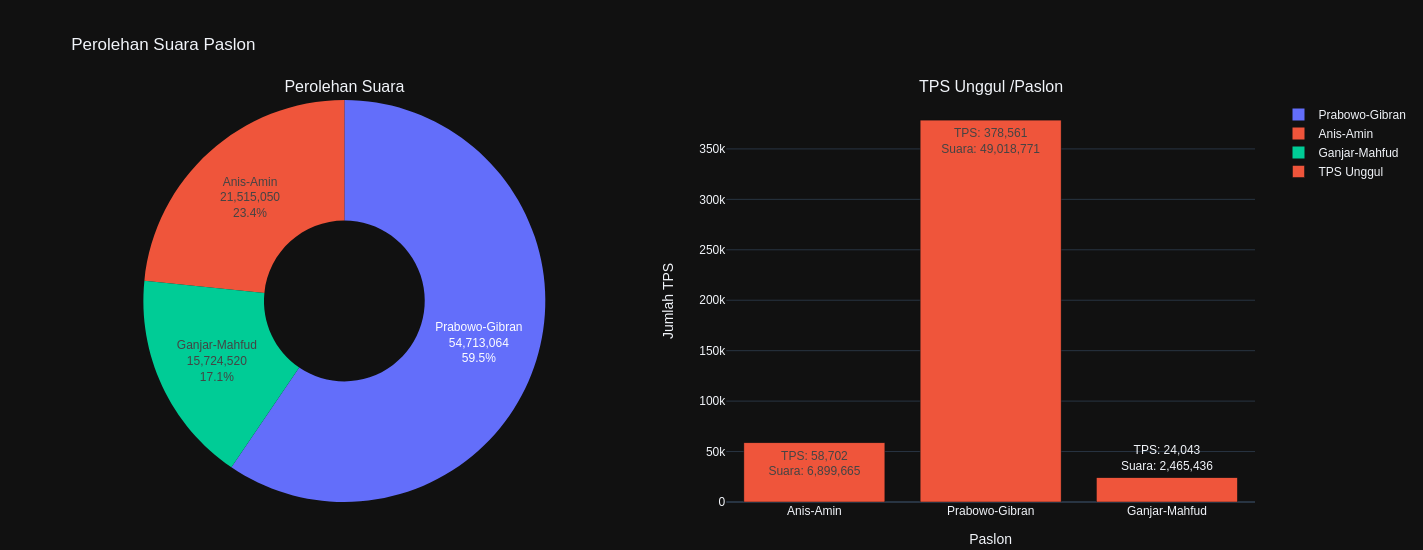

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

paslon1_suara_terbanyak = data_normal[(data_normal.paslon01 > data_normal.paslon02) & (data_normal.paslon01 > data_normal.paslon03)]
paslon2_suara_terbanyak = data_normal[(data_normal.paslon02 > data_normal.paslon01) & (data_normal.paslon02 > data_normal.paslon03)]
paslon3_suara_terbanyak = data_normal[(data_normal.paslon03 > data_normal.paslon02) & (data_normal.paslon03 > data_normal.paslon02)]

labels = ["Anis-Amin", "Prabowo-Gibran", "Ganjar-Mahfud"]
suara_paslon = [data_normal.paslon01.sum(), data_normal.paslon02.sum(), data_normal.paslon03.sum()]


jumlah_tps_unggul_paslon = [paslon1_suara_terbanyak.tps.count(), paslon2_suara_terbanyak.tps.count(), paslon3_suara_terbanyak.tps.count()]
jumlah_suara_unggul_paslon = [paslon1_suara_terbanyak.paslon01.sum(), paslon2_suara_terbanyak.paslon02.sum(), paslon3_suara_terbanyak.paslon03.sum()]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'bar'}]], subplot_titles=['Perolehan Suara', "TPS Unggul /Paslon"])

fig.add_trace(go.Pie(labels=labels, values=suara_paslon, textinfo='percent+value+label', name="Suara Paslon", hole=.4, hoverinfo="label+percent+value"), 1, 1)
fig.add_trace(go.Bar(x=labels, y=jumlah_tps_unggul_paslon, text=[f"TPS: {it:,}<br>Suara: {it2:,}" for it, it2 in zip(jumlah_tps_unggul_paslon, jumlah_suara_unggul_paslon)], hoverinfo='x+text', name="TPS Unggul"), 1, 2)
# fig.add_trace(go.Scatter(x=labels, y=jumlah_suara_unggul_paslon, text=[f"{it:,}" for it in jumlah_suara_unggul_paslon], hoverinfo='x+text', name="Jumlah Suara Unggul"), 1, 2)

fig.update_layout(
    title_text="Perolehan Suara Paslon",
    autosize=True,
    height=550,
    yaxis_title="Jumlah TPS",
    xaxis_title="Paslon",
    margin=dict(b=5,)
)
fig.show()

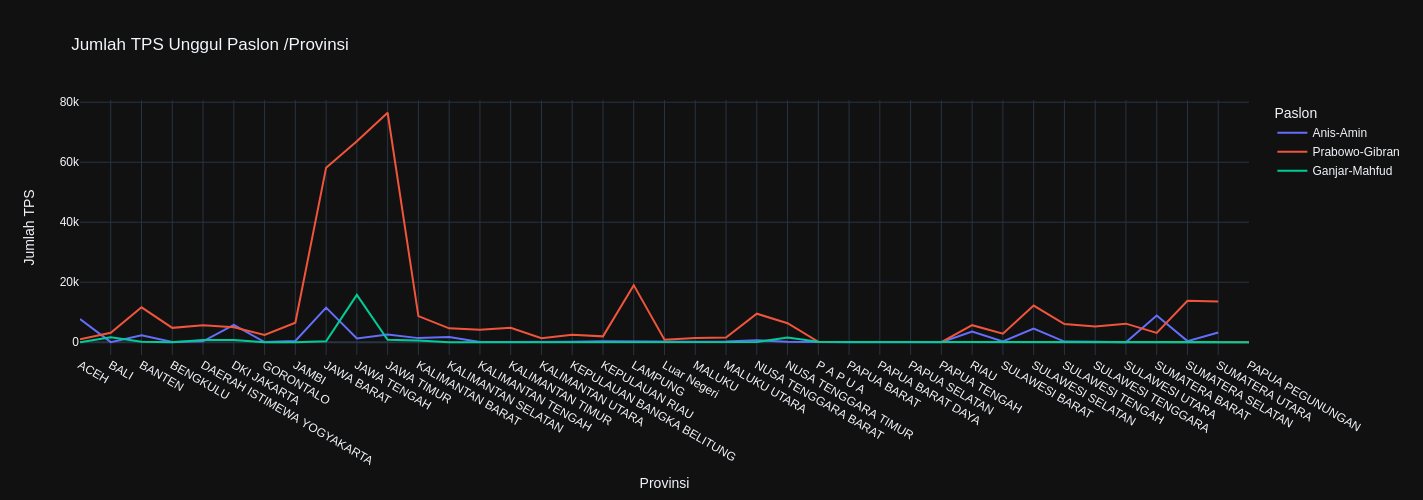

In [30]:
fig = go.Figure()

paslon1_suara_terbanyak_group = paslon1_suara_terbanyak.groupby('provinsi').tps.count()
paslon2_suara_terbanyak_group = paslon2_suara_terbanyak.groupby('provinsi').tps.count()
paslon3_suara_terbanyak_group = paslon3_suara_terbanyak.groupby('provinsi').tps.count()

paslon1_suara_group = paslon1_suara_terbanyak.groupby('provinsi').paslon01.sum()
paslon2_suara_group = paslon2_suara_terbanyak.groupby('provinsi').paslon02.sum()
paslon3_suara_group = paslon3_suara_terbanyak.groupby('provinsi').paslon03.sum()


fig.add_trace(go.Scatter(name='Anis-Amin', hoverinfo="x+name+text", 
                         text=[f"{tps:,} <br>Suara: {suara:,}" for tps, suara in zip(paslon1_suara_terbanyak_group, paslon1_suara_group)], 
                         y=paslon1_suara_terbanyak_group.values, 
                         x=paslon1_suara_terbanyak_group.index))

fig.add_trace(go.Scatter(name='Prabowo-Gibran', hoverinfo="x+name+text", 
                         text=[f"{tps:,} <br>Suara: {suara:,}" for tps, suara in zip(paslon2_suara_terbanyak_group, paslon2_suara_group)],
                         y=paslon2_suara_terbanyak_group.values, 
                         x=paslon2_suara_terbanyak_group.index))

fig.add_trace(go.Scatter(name='Ganjar-Mahfud', hoverinfo="x+name+text", 
                         text=[f"{tps:,} <br>Suara: {suara:,}" for tps, suara in zip(paslon3_suara_terbanyak_group, paslon3_suara_group)], 
                         y=paslon3_suara_terbanyak_group.values, 
                         x=paslon3_suara_terbanyak_group.index))

fig.update_layout(hovermode='x unified')

fig.update_layout(
    title="Jumlah TPS Unggul Paslon /Provinsi",
    xaxis_title="Provinsi",
    yaxis_title="Jumlah TPS",
    legend_title="Paslon",
    autosize=True,
    height=500)
fig.show()

# data_normal.to_csv('suara_sesuai.csv', index=False)
data_cluttered.to_csv('suara_tidak_sesuai.csv', index=False)
progressed_suara_lebih.to_csv('suara_lebih.csv', index=False)
progressed_suara_kurang.to_csv('suara_kurang.csv', index=False)

In [32]:
from pathlib import Path

In [33]:
progress_file = Path('dataset/progress.csv')

In [34]:
def create_progress_file():
    if not progress_file.exists():
        with open(str(progress_file), 'a') as f:
            f.write("dataset,suara_masuk,suara_belum_masuk,suara_sesuai,suara_tidak_sesuai,inprogress,suara_lebih,suara_kurang,paslon01_lebih,paslon01_kurang,paslon02_lebih,paslon02_kurang,paslon03_lebih,paslon03_kurang,suara_sesuai_paslon01,suara_sesuai_paslon02,suara_sesuai_paslon03,tps_unggul_paslon01,tps_unggul_paslon02,tps_unggul_paslon03,suara_tps_unggul_paslon01,suara_tps_unggul_paslon02,suara_tps_unggul_paslon03\n")

def write_progress(*data):
    with open(str(progress_file), 'a') as f:
        f.write(f"{','.join(map(str, data))}\n")

In [35]:
create_progress_file()

In [36]:
write_progress(dataset_date_str(),
               suara_masuk.tps.count(),
               suara_belum_masuk.tps.count(),
               data_normal.tps.count(),
               data_cluttered.tps.count(),
               inprogress.tps.count(),
               progressed_suara_lebih.tps.count(),
               progressed_suara_kurang.tps.count(),
               paslon1_lebih.tps.count(),
               paslon1_kurang.tps.count(),
               paslon2_lebih.tps.count(),
               paslon2_kurang.tps.count(),
               paslon3_lebih.tps.count(),
               paslon3_kurang.tps.count(),
               *suara_paslon,
               *jumlah_tps_unggul_paslon,
               *jumlah_suara_unggul_paslon
              )